# RGI16 (Low Latitudes)

F. Maussion & S. Galos

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, open_zip_shapefile, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 16

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '16_rgi60_LowLatitudes.zip')

# Support data dir
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, df_class = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
407,8,2.2,Kincaid,Kincaid,2007,Irian Jaya,2002,2002,2002
461,14,2.0,Helm,Helm,2007,Various (NSIDC),2004,2004,2004
476,705,509.1,Racoviteanu,Racoviteanu,2008,"Cordillera Blanca, Peru",2003,2003,2003
479,7,2.3,Kincaid,Kincaid,2007,Irian Jaya,2000,2000,2000
489,905,459.7,Racoviteanu,Racoviteanu,2008,"Cordillera Blanca, Peru",2005,2005,2005
591,2901,2314.1,"Kienholz, Miles, Sharp, Wyatt",Cogley,2015,Randolph Glacier Inventory; Umbrella RC for me...,2000,1990,2009
648,4,0.5,Shuman,Shuman,2018,Irian Jaya,2018,2018,2018
649,6,0.6,Shuman,Shuman,2018,Irian Jaya,2015,2015,2015
650,10,1.3,Shuman,Shuman,2018,Irian Jaya,2009,2009,2009


In [5]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

Notes based on inidivual submission evaluations: 
- 407 is Papua New Guinea, RGI6 is probably based on these but its not exact same. It is covered by 591 as well
- 461 is Kibo, but another date than RGI6 (which is 2000) and different
- 479 also Papua New Guinea, also similar to RGI6 (id 591) but not exact same
- 591 is RGI6, from what I can see spatially complete (already detected a geometry problem at Mt Kibo and different outlines in Ecuador)
- 648-649 are all Papua New Guina. 652 is closer to 2000 than RGI6 (2002), but the outlines look more pixelated. They are also shifted to RGI6, so no clue which is best
- 672-690 are all outlines of the same ice field in Peru, at various dates
- 692-693 a few outlines in Bolivia
- 700 is from the Argentina inventory. It contains many many more outlines than RGI6 in argentina (only a handful of RGI6 outlines in Argentina). Many of the features look like rock glaciers (or just rocks): the good thing is, they are classified as rock glaciers in GLIMS (primeclass 9).
- 730 is from the Chilean inventory. Same issues as with 700. Many outlines, many of them looking like rock glaciers. Unfortunately, the Chilean inventory in GLIMS does not have classification (all are class 0 "unspecified"). The original data however seems to be fine so we can use to correct GLIMS (to be ficxed upstream though)
- 748 is a recent inventory for Peru, Bolivia, and Northern Chile
- 753 is an update to Cotopaxi: https://github.com/GLIMS-RGI/rgi7_scripts/issues/30
- 760 is an update to Kibo: https://github.com/GLIMS-RGI/rgi7_scripts/issues/31

In [6]:
sel_invs = [591, 700, 730, 748, 753, 760]
shp = shp.loc[shp.subm_id.isin(sel_invs)]
df_class.loc[sel_invs]

,N,N Ice-field,N NA,N Valley gl,N Glacieret,N Rock gl,N Moutain gl
subm_id,,,,,,,
591,2901,0,2901,0,0,0,0
700,856,0,0,0,17,838,1
730,416,0,416,0,0,0,0
748,3534,0,3534,0,0,0,0
753,4,0,4,0,0,0,0
760,1,0,1,0,0,0,0


### Attributes of the chilean inventory 

The Chilean inventory was ingested without attributes in GLIMS. Let's correct that:

In [7]:
chile = open_zip_shapefile(support_dir + '/Shape_Inventario_de_Glaciares.zip')
chile = chile.to_crs(shp.crs)

In [8]:
# There is a duplicated ID in the original inventory and therefore in GLIMS
chile = chile.drop(20896).copy()
shp = shp[shp.anlys_id != 751799].copy()

In [9]:
# Convert the spanish classes into WGMS classification
translate = {'GLACIAR DE MONTAÑA':6, 'GLACIARETE':7, 'GLACIAR ROCOSO': 9}
chile = chile.replace({"CLASIFICA": translate})

In [10]:
reg_f = gpd.read_file( os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions'))
shp_chile = shp.loc[shp['subm_id'] == 730]

rp = chile.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = chile.index
intersect = gpd.overlay(rp, reg_f.loc[reg_f.o1region == f'{reg:02d}'], how='intersection')
chile = chile.loc[intersect['orig_index']]

# assert len(chile) == len(shp_chile) <- this used to pass but it doesnt since https://github.com/GLIMS-RGI/rgi7_scripts/issues/44

/home/users/fmaussion/.miniconda3/envs/oggm_env/lib/python3.10/site-packages/geopandas/tools/overlay.py:299: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[mask, col] = df.loc[mask, col].buffer(0)


In [11]:
rp = shp_chile.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = shp_chile.index
intersect = gpd.overlay(rp, chile, how='intersection')

# assert len(intersect) == len(chile) <- this used to pass but it doesnt since https://github.com/GLIMS-RGI/rgi7_scripts/issues/44

In [12]:
shp.loc[intersect.orig_index, 'primeclass'] = intersect["CLASIFICA"].values.astype(int)

In [13]:
sdf, df_class = submission_summary(shp)
df_class

,N,N NA,N Glacieret,N Rock gl,N Moutain gl
subm_id,,,,,
591,2901,2901,0,0,0
700,856,0,17,838,1
730,415,0,7,395,13
748,3534,3534,0,0,0
753,4,4,0,0,0
760,1,1,0,0,0


In [14]:
# Exclude rock glaciers
shp = shp.loc[shp.primeclass != 9]

In [15]:
sdf, df_class = submission_summary(shp)
df_class

,N,N NA,N Glacieret,N Moutain gl
subm_id,,,,
591,2901,2901,0,0
700,18,0,17,1
730,20,0,7,13
748,3534,3534,0,0
753,4,4,0,0
760,1,1,0,0


In [16]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_sel_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_sel_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_sel_inventories']))

## Outline selection 

For this region we do things a bit differently. Start with easy things, all smaller subregions in the Tropics first:

In [17]:
reg_f = gpd.read_file(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O2Regions'))
reg_f = reg_f.loc[reg_f['o2region'].str.contains('16-')]
reg_f

,o1region,o2region,full_name,long_code,geometry
63,16,16-01,Low-latitude Andes,16-01_low_latitude_andes,"POLYGON ((-62.00000 -25.00000, -63.00000 -25.0..."
64,16,16-02,Mexico,16-02_mexico,"POLYGON ((-100.00000 18.00000, -100.00000 19.0..."
65,16,16-03,East Africa,16-03_east_africa,"POLYGON ((28.00000 -5.00000, 28.00000 -4.00000..."
66,16,16-04,New Guinea,16-04_new_guinea,"POLYGON ((135.00000 -6.00000, 135.00000 -5.000..."


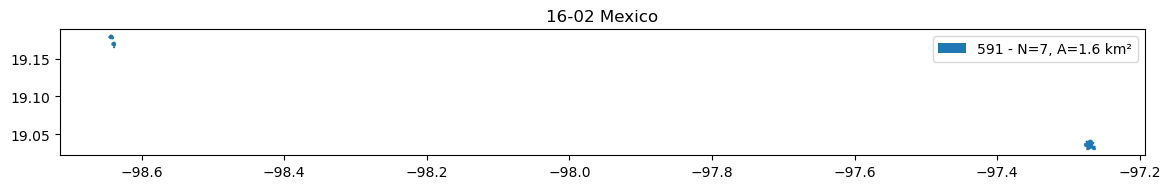

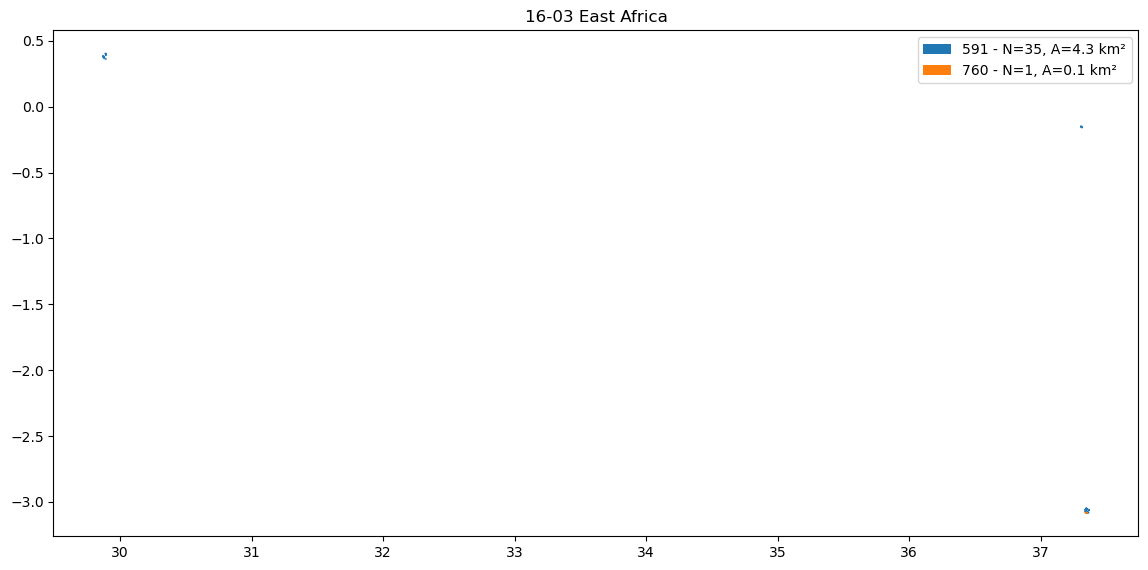

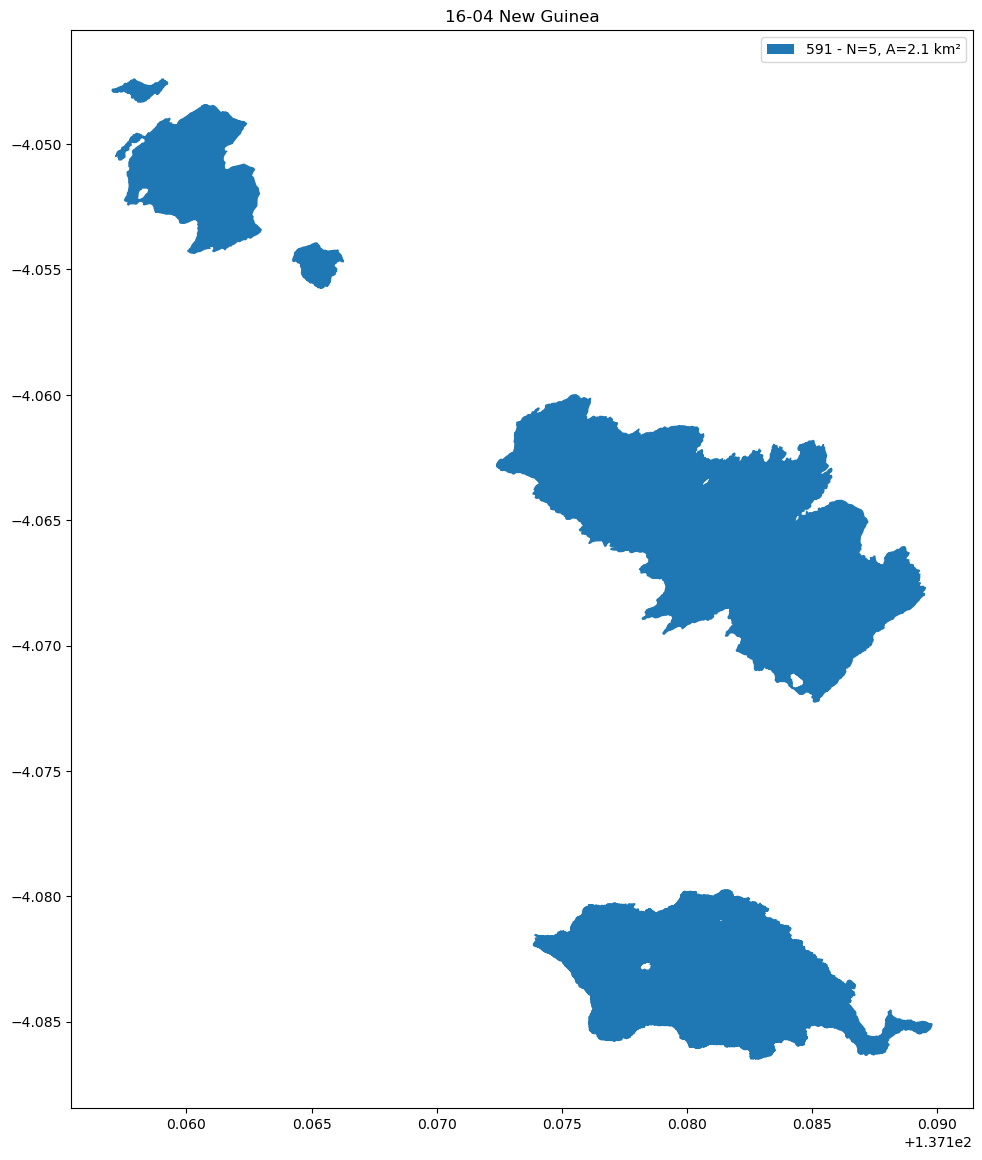

In [18]:
rp = shp.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = shp.index

per_sreg = dict()
for i in reg_f.iloc[1:].index:
    intersect = gpd.overlay(rp, reg_f.loc[[i]], how='intersection')
    
    sel_sreg = shp.loc[intersect.orig_index].copy()
    sel_sreg['is_rgi6'] = True
    
    per_sreg[reg_f.loc[i].o2region] = sel_sreg
    
    plot_map(sel_sreg, reg, title=reg_f.loc[i].o2region + ' ' +  reg_f.loc[i].full_name, savefig=False)

Ok now, just the Andes:

In [19]:
intersect = gpd.overlay(rp, reg_f.iloc[[0]], how='intersection')
shp = shp.loc[intersect.orig_index].copy()

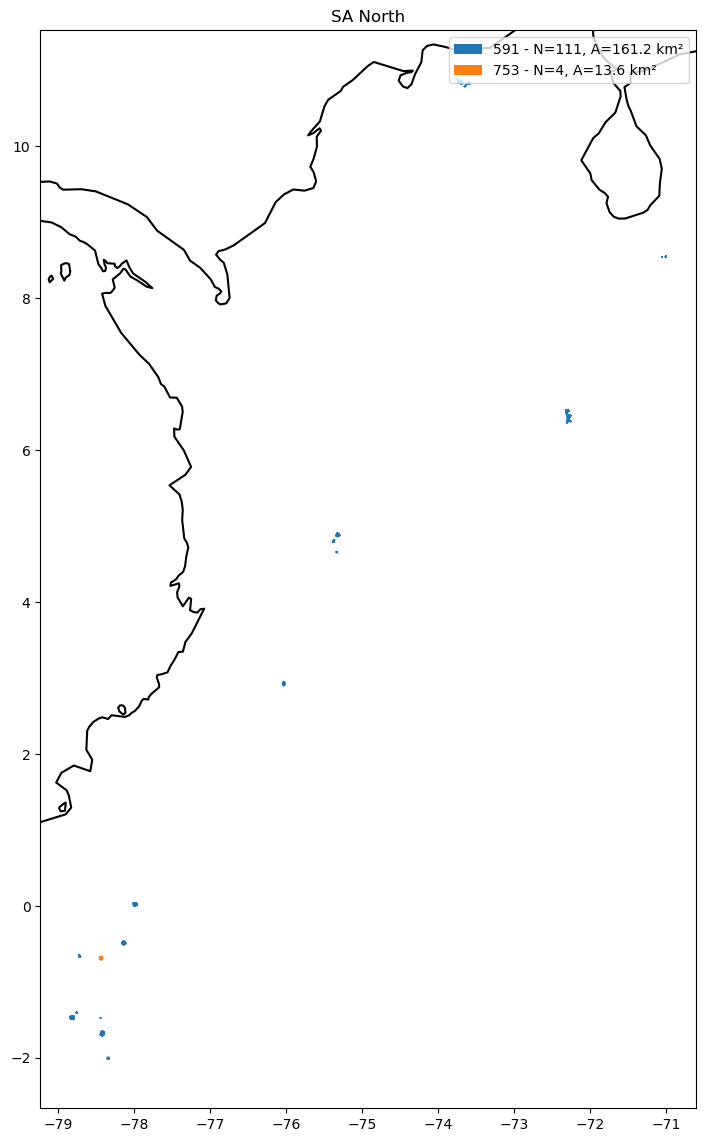

In [20]:
# North of Peru, we use previous RGI:
rgi7_sa_north = shp.loc[(shp.subm_id.isin([591, 753, 760]) & (shp.CenLat > -7))].copy()
rgi7_sa_north['is_rgi6'] = True
plot_map(rgi7_sa_north, reg, title='SA North', savefig=False)

In [21]:
# For Peru and Bolivia, we use the new inventory from Zürich, except at the Chile/Bolivia border
exlude = open_zip_shapefile(support_dir + '/exclude_748.zip')

rgi7_sa_fp = shp.loc[shp.subm_id == 748].copy()
rgi7_sa_fp['is_rgi6'] = False

rp = rgi7_sa_fp.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi7_sa_fp.index
difference = gpd.overlay(rp, exlude, how='difference')

bef = len(rgi7_sa_fp)
rgi7_sa_fp = rgi7_sa_fp.loc[difference['orig_index']].copy()
assert bef - len(rgi7_sa_fp)  == 37 # This should be 37 less, I counted

In [22]:
# OK, and then the Chile and Argentinian invs
rgi7_chile = shp.loc[shp.subm_id == 730].copy()
rgi7_chile['is_rgi6'] = False
rgi7_arg = shp.loc[shp.subm_id == 700].copy()
rgi7_arg['is_rgi6'] = False

In [23]:
rgi7 = pd.concat(per_sreg.values())
rgi7 = pd.concat([rgi7, rgi7_sa_north, rgi7_sa_fp, rgi7_chile, rgi7_arg])

### Some sanity checks 

In [24]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [25]:
rgi7 = correct_geoms(rgi7)

Found 445 invalid geometries out of 3698. Correcting...
After correction, 0 geometries are still invalid.
Area changed by -0.2 m2 (-0.0000%)


In [26]:
needs_size_filter(rgi7)

False

In [27]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA,N Moutain gl,N Glacieret
subm_id,,,,
591,158,158,0,0
760,1,1,0,0
753,4,4,0,0
748,3497,3497,0,0
730,20,0,13,7
700,18,0,1,17


In [28]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

In [29]:
# Check that some ice patches that were tagged as snow dring review are not there
# https://github.com/GLIMS-RGI/rgi7_scripts/issues/44
assert rgi7.anlys_id.isin([766996, 309526, 310668]).sum() == 0

### Plots 

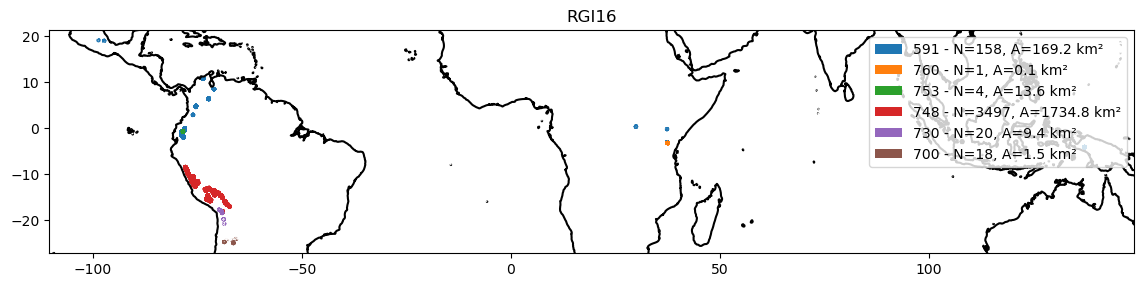

In [30]:
plot_map(rgi7, reg, linewidth=3)

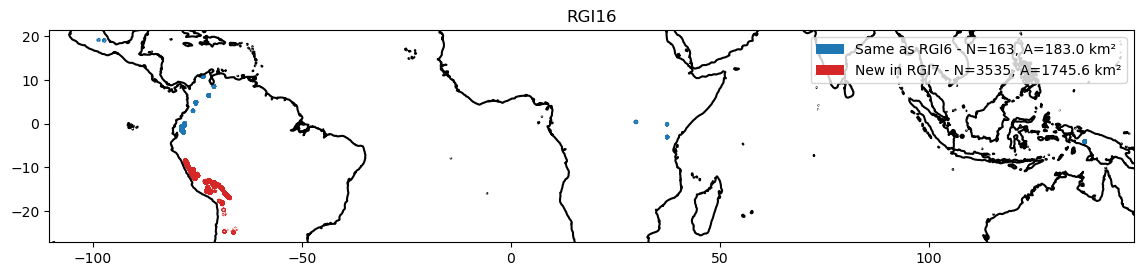

In [31]:
plot_map(rgi7, reg, linewidth=3, is_rgi6=True)

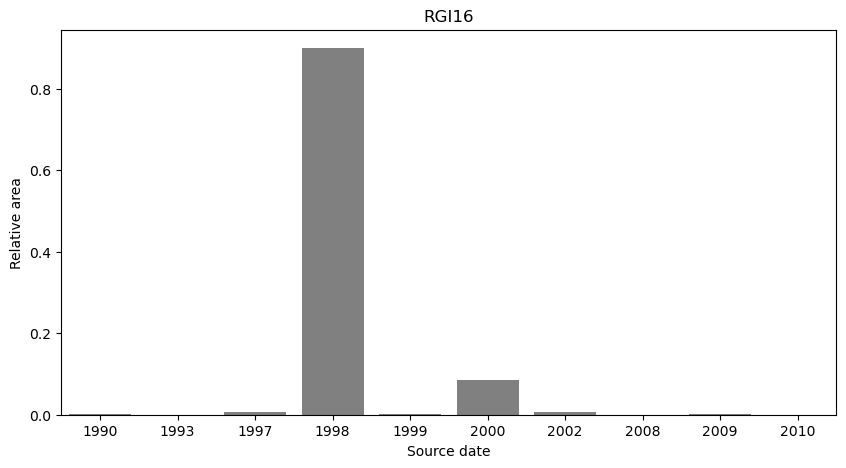

In [32]:
plot_date_hist(rgi7, reg)

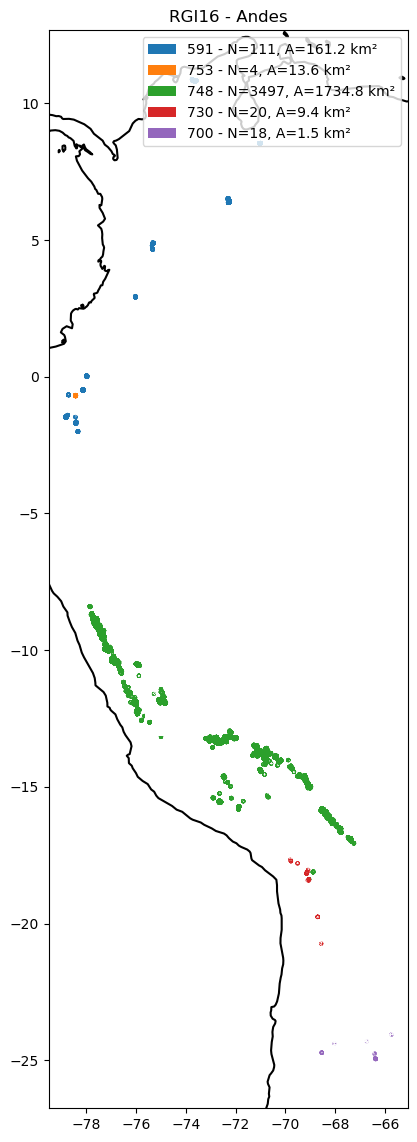

In [33]:
plot_map(pd.concat([rgi7_sa_north, rgi7_sa_fp, rgi7_chile, rgi7_arg]), reg, linewidth=3, title='RGI16 - Andes', savefig=False)

### Text for github

In [34]:
fgh = sdf.T
fgh

subm_id,591,760,753,748,730,700
N,158,1,4,3497,20,18
A,169.2,0.1,13.6,1734.8,9.4,1.5
analysts,"Kienholz, Miles, Sharp, Wyatt","Kienholz, Miles, Sharp, Wyatt","Cáceres, Francou, Jordan, Peñafiel, Ungerechts","Goerlich, Paul, Rastner","Albornoz, Arias, Barcaza, Garcia, Nussbaumer, ...","Castro, Gargantini, Gimenez, Hidalgo, Masiokas..."
submitters,Cogley,Maussion,Maussion,Paul,Barcaza,Hidalgo
release_date,2015,2022,2022,2021,2018,2018
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,Randolph Glacier Inventory; Umbrella RC for me...,Randolph Glacier Inventory; Umbrella RC for me...,Various (GlobGlacier),"Chilean glaciers, between -18 and -56 degrees ...",Argentina
src_date_mode,2000,2000,1997,1998,2002,2009
src_date_min,1990,2000,1997,1998,2002,2008
src_date_max,2002,2000,1997,1998,2002,2010


In [35]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 591                                                                    | 760                                                                    | 753                                                                    | 748                     | 730                                                                 | 700                                                                                   |
|:--------------|:-----------------------------------------------------------------------|:-----------------------------------------------------------------------|:-----------------------------------------------------------------------|:------------------------|:--------------------------------------------------------------------|:--------------------------------------------------------------------------------------|
| N             | 158                                                                    | 1                                                                  

## Write out and tar 

In [36]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI16/
RGI16/RGI16.shx
RGI16/RGI16.prj
RGI16/RGI16.cpg
RGI16/RGI16.dbf
RGI16/RGI16.shp
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI16.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI16'], returncode=0)
